In [1]:
import logging
import numpy as np
import pandas as pd
import h5py as h5
from collections import namedtuple

In [2]:
'''
logging.basicConfig(level=1, format='[%(asctime)s %(levelname)s] %(message)s')
Option = namedtuple("MyStruct", "input train_size")
                    # model name folds batch_size epochs")
                    #structure learning_rate regularizer epochs")
args = Option(
    #input=,
    #train_size = 0.75
    #model='share/reference_number.py',
    #name='NumberNetworkKFOLD',
    #folds=10,
    #batch_size=60,
    #epochs=20,
    #learning_rate=0.0001,
    #regularizer=0.0001,
)
'''

'\nlogging.basicConfig(level=1, format=\'[%(asctime)s %(levelname)s] %(message)s\')\nOption = namedtuple("MyStruct", "input train_size")\n                    # model name folds batch_size epochs")\n                    #structure learning_rate regularizer epochs")\nargs = Option(\n    #input=,\n    #train_size = 0.75\n    #model=\'share/reference_number.py\',\n    #name=\'NumberNetworkKFOLD\',\n    #folds=10,\n    #batch_size=60,\n    #epochs=20,\n    #learning_rate=0.0001,\n    #regularizer=0.0001,\n)\n'

# Load Data

Load from one file

In [37]:
infile = 'jz7w_barrel.h5'

logging.info(f'Loading data from data/{infile}')

with h5.File('data/'+infile, 'r') as data:
    data_x = data['input'][()]
    data_y = data['target'][()]

Load from endcap, barrel, ibl files

In [4]:
with h5.File('data/oldjz7wendcapwithflip.h5', 'r') as data:
    data_x = data['input'][:int(5e6)]
    data_y = data['target'][:int(5e6)]
with h5.File('data/oldjz7wiblwithflip.h5', 'r') as data:
    data_x = np.append(data_x, data['input'][:int(5e6)], axis=0)
    data_y = np.append(data_y, data['target'][:int(5e6)], axis=0)
with h5.File('data/oldjz7wbarrelwithflip.h5', 'r') as data:
    data_x = np.append(data_x, data['input'][:int(5e6)], axis=0)
    data_y = np.append(data_y, data['target'][:int(5e6)], axis=0)

In [38]:
data_x.shape

(20000000, 60)

#### Exploring data structure

In [5]:
import matplotlib.pyplot as plt

In [39]:
data_y_copy = np.copy(data_y)
data_y_copy[:,1] *= 2
data_y_copy[:,2] *= 3

In [40]:
data_y_copy

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 3.],
       ...,
       [0., 0., 3.],
       [0., 0., 3.],
       [0., 0., 3.]], dtype=float32)

In [41]:
hist = np.histogram(data_y_copy, bins=[0,1,2,3])
hist

(array([40000000,  4400000, 15600000], dtype=int64), array([0, 1, 2, 3]))

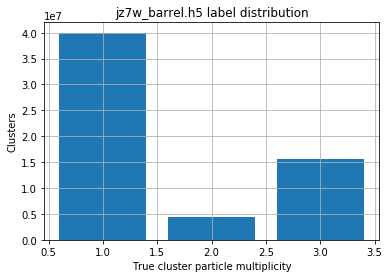

In [42]:
plt.bar(hist[1][1:], hist[0])
plt.ylabel(f"Clusters")
plt.xlabel(f"True cluster particle multiplicity")
plt.grid(True)
plt.title(f'{infile} label distribution')
plt.savefig(f'output/{infile}_label_distribution.png')
plt.show()
plt.close()

# Shuffle Data

In [10]:
logging.info('Shuffling')
rng = np.random.default_rng(seed=42)
s = np.arange(data_x.shape[0])
rng.shuffle(s)

data_x = data_x[s]
data_y = data_y[s]

In [12]:
outfile = 'data/jz7w_shuffled.h5'

with h5.File(outfile, 'w') as hfile:
    hfile.create_dataset('input', data=data_x.astype(np.float32), compression='gzip')
    hfile.create_dataset('target', data=data_y.astype(np.float32), compression='gzip')

In [17]:
train_split = range(int(12e6))
train_split

range(0, 12000000)

In [18]:
test_split = range(int(12e6), data_x.shape[0])
test_split

range(12000000, 17000000)

# Create Train and Test splits

In [27]:
outtrain = 'jz7w_train.h5'
outtest = 'jz7w_test.h5'

with h5.File('data/'+outtrain, 'w') as hfile:
    hfile.create_dataset('input', data=data_x[train_split].astype(np.float32), compression='gzip')
    hfile.create_dataset('target', data=data_y[train_split].astype(np.float32), compression='gzip')

with h5.File('data/'+outtest, 'w') as hfile:
    hfile.create_dataset('input', data=data_x[test_split].astype(np.float32), compression='gzip')
    hfile.create_dataset('target', data=data_y[test_split].astype(np.float32), compression='gzip')

# Create 10 Splits

In [20]:
for i in range(10):
    with h5.File(f'data/split{i+1}.h5', 'w') as hfile:
        hfile.create_dataset('input', data=data_x[int(data_x.shape[0]/10)*i:int(data_x.shape[0]/10)*(i+1)].astype(np.float32), compression='gzip')
        hfile.create_dataset('target', data=data_y[int(data_x.shape[0]/10)*i:int(data_x.shape[0]/10)*(i+1)].astype(np.float32), compression='gzip')
